Geometry: NDBR50, Epoch [100/1000], Loss: 284165.6562
Geometry: NDBR50, Epoch [200/1000], Loss: 278248.5000
Geometry: NDBR50, Epoch [300/1000], Loss: 268050.8438
Geometry: NDBR50, Epoch [400/1000], Loss: 254232.7344
Geometry: NDBR50, Epoch [500/1000], Loss: 237879.7656
Geometry: NDBR50, Epoch [600/1000], Loss: 219923.4219
Geometry: NDBR50, Epoch [700/1000], Loss: 201207.6406
Geometry: NDBR50, Epoch [800/1000], Loss: 182445.2344
Geometry: NDBR50, Epoch [900/1000], Loss: 164196.9219
Geometry: NDBR50, Epoch [1000/1000], Loss: 146919.5156
Geometry: NDBR6, Epoch [100/1000], Loss: 283847.1562
Geometry: NDBR6, Epoch [200/1000], Loss: 277997.5312
Geometry: NDBR6, Epoch [300/1000], Loss: 267995.0938
Geometry: NDBR6, Epoch [400/1000], Loss: 254334.5625
Geometry: NDBR6, Epoch [500/1000], Loss: 238169.4844
Geometry: NDBR6, Epoch [600/1000], Loss: 220437.2500
Geometry: NDBR6, Epoch [700/1000], Loss: 201958.3594
Geometry: NDBR6, Epoch [800/1000], Loss: 183431.3438
Geometry: NDBR6, Epoch [900/1000], 

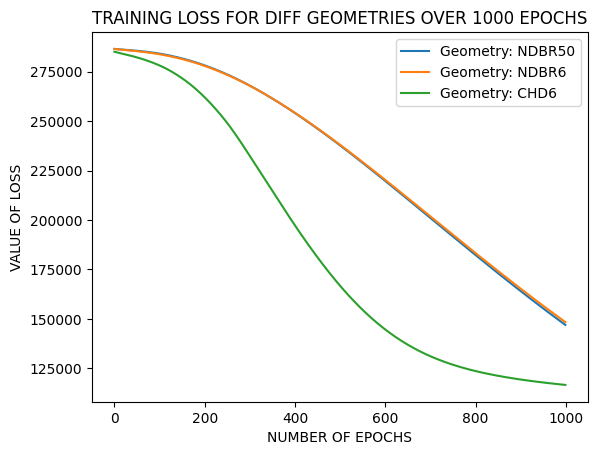

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

paramConfig = {
    'c1': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1.0, 'name': 'W', 'unit': 'dimensionless', 'type': 'hardening'},
    'c2': {'lowerBound': 0, 'upperBound': 2, 'exponent': 1000.0, 'name': 'K', 'unit': 'MPa', 'type': 'yielding'},
    'c3': {'lowerBound': 0, 'upperBound': 1, 'exponent': 0.1, 'name': 'e0', 'unit': 'dimensionless', 'type': 'hardening'},
    'c4': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1.0, 'name': 'n', 'unit': 'dimensionless', 'type': 'hardening'},
    'c5': {'lowerBound': 0, 'upperBound': 2, 'exponent': 1000.0, 'name': 'sigma_y', 'unit': 'MPa', 'type': 'yielding'},
    'c6': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1000.0, 'name': 'sigma_sat', 'unit': 'MPa', 'type': 'hardening'},
    'c7': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1000.0, 'name': 'b', 'unit': 'dimensionless', 'type': 'hardening'}
}



geometries = ['NDBR50', 'NDBR6', 'CHD6']
yieldingIndices = {'NDBR50': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files in the "MODELS" folder
X_files = {
    'NDBR50': "MODEL_DATA/NDBR50_FD_Curve.csv",
    'NDBR6': "MODEL_DATA/NDBR6_FD_Curve.csv",
    'CHD6': "MODEL_DATA/CHD6_FD_Curve.csv"
}
Y_file = "MODEL_DATA/commonHardParam.csv"

# Convert the data to PyTorch tensors
X_train = {geometry: None for geometry in geometries}
Y_train = torch.tensor(pd.read_csv(Y_file).values, dtype=torch.float32)

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Add parameters for Swift-Voce law
        self.A = nn.Parameter(torch.randn(1, requires_grad=True))
        self.B = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# Define the number of input features, hidden units, and output dimensions
input_size = 2  # Number of input parameters
hidden_size = 64  # Number of hidden units
output_size = 7  # Number of output dimensions

# Create an instance of the neural network for each geometry
models = {geometry: NeuralNetwork(input_size, hidden_size, output_size) for geometry in geometries}

# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizers = {geometry: optim.Adam(models[geometry].parameters(), lr=0.001) for geometry in geometries}

# Training loop
num_epochs = 1000  # Adjust the number of epochs as needed

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

def swift_voce_loss(outputs, Y_sample, A, B):

    predicted_parameters = Y_sample[:, 4] + A * (1 - torch.exp(-B * Y_sample[:, 2]))

    predicted_parameters = predicted_parameters.view(Y_sample.shape[0], 1)

    # Calculate the loss using mean squared error
    loss = criterion(outputs, Y_sample)
    return loss


for geometry in geometries:
    num_samples = yieldingIndices[geometry]  # Use the yielding index for the current geometry

    # Load the X data for the current geometry and use the first 2 columns
    X_file = X_files[geometry]
    X_df = pd.read_csv(X_file)
    X_train[geometry] = torch.tensor(X_df.iloc[:, :2].values, dtype=torch.float32)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = models[geometry](X_train[geometry][:num_samples])

        # Compute the loss
        loss = swift_voce_loss(outputs, Y_train[:num_samples], models[geometry].A, models[geometry].B)

        # Backpropagation and optimization
        optimizers[geometry].zero_grad()
        loss.backward()
        optimizers[geometry].step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# Plot the loss for each geometry in a single graph
for geometry in geometries:
    plt.plot(loss_lists[geometry], label=f'Geometry: {geometry}')

# Rest of your code for prediction and visualization
plt.xlabel('NUMBER OF EPOCHS')
plt.ylabel('VALUE OF LOSS')
plt.legend()
plt.title('TRAINING LOSS FOR DIFF GEOMETRIES OVER 1000 EPOCHS')
plt.show()

